In [1]:
import time

import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tfp.math.psd_kernels
tf.enable_v2_behavior()

from mpl_toolkits.mplot3d import Axes3D
%pylab inline
# Configure plot defaults
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['grid.color'] = '#666666'
%config InlineBackend.figure_format = 'png'

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# GP with Correlated Bins for Vector Statistics

We assume separate kernels for x and k bins, and isotropic kernels for each.

K = K({x, k}, {x', k'}) = K(x, x') K(k, k')

Main purpose is to see if the emulation accuracy increases with K(k, k')

In [2]:
# Fourier k modes
kf = np.loadtxt("../data/360_res128box256_9_res512box256_z0/kf.txt")

# X is the input cosmological parameters, (Omega_m, Omega_0, h, A_s, n_s)
X = np.loadtxt("../data/360_res128box256_9_res512box256_z0/train_input_fidelity_0.txt")
# lower and upper bounds (prior volume) of the cosmological parameters
param_limits = np.loadtxt("../data/360_res128box256_9_res512box256_z0/input_limits.txt")

# Y is the power spectrum, P(k)
Y = np.loadtxt("../data/360_res128box256_9_res512box256_z0/train_output_fidelity_0.txt")


In [3]:
def map_to_unit_cube(param_vec, param_limits):
    """
    Map a parameter vector to the unit cube from the original dimensions of the space.
    Arguments:
    param_vec - the vector of parameters to map.
    param_limits - the limits of the allowed parameters.
    Returns:
    vector of parameters, all in [0,1].
    """
    assert (np.size(param_vec),2) == np.shape(param_limits)
    assert np.all(param_vec-1e-16 <= param_limits[:,1])
    assert np.all(param_vec+1e-16 >= param_limits[:,0])
    ii = np.where(param_vec > param_limits[:,1])
    param_vec[ii] = param_limits[ii,1]
    ii = np.where(param_vec < param_limits[:,0])
    param_vec[ii] = param_limits[ii,0]
    assert np.all(param_limits[:,0] <= param_limits[:,1])
    new_params = (param_vec-param_limits[:,0])/(param_limits[:,1] - param_limits[:,0])
    assert np.all((new_params >= 0)*(new_params <= 1))
    return new_params

def map_to_unit_cube_list(param_vec_list, param_limits):
    """Map multiple parameter vectors to the unit cube"""
    return np.array([map_to_unit_cube(param_vec, param_limits) for param_vec in param_vec_list])

def input_normalize(
    params: np.ndarray, param_limits: np.ndarray
) -> np.ndarray:
    """
    Map the parameters onto a unit cube so that all the variations are
    similar in magnitude.
    
    :param params: (n_points, n_dims) parameter vectors
    :param param_limits: (n_dim, 2) param_limits is a list 
        of parameter limits.
    :return: params_cube, (n_points, n_dims) parameter vectors 
        in a unit cube.
    """
    nparams = np.shape(params)[1]
    params_cube = map_to_unit_cube_list(params, param_limits)
    assert params_cube.shape[1] == nparams

    return params_cube


In [4]:
# Normalize input to a [0 - 1] Latin Hypercube
# This is to avoid the lengthscale & amplitude prior
# to hard to define
X = input_normalize(X, param_limits=param_limits)

# Normalized: Here we substract the P(k) with its mean at a certain k,
# P(k= k') <- P(k= k') - Mean(P(k = k')) 
Y_mean = Y.mean(axis=0)
_Y_old = Y
Y = (Y - Y_mean)

Since we have a kernel over k, the GP is modeling

f( k = k', x = x' ) ~ GP( mu | K )

instead of 

f(k, x = x') ~ GP(mu | K)

So instead of building a batch of independet GPs, we just build one GP and flatten out the vector output.

In [5]:
# discard some bins since no need to have many
skip = 1
_kf = kf[::skip]
Y = Y[::skip]
Y_mean = Y_mean[::skip]

# normalize k bins, since this will also be input.
_kf = (_kf - np.min(_kf)) / (np.max(_kf) - np.min(_kf))

num_kf = _kf.shape[0]

_kf.shape

(96,)

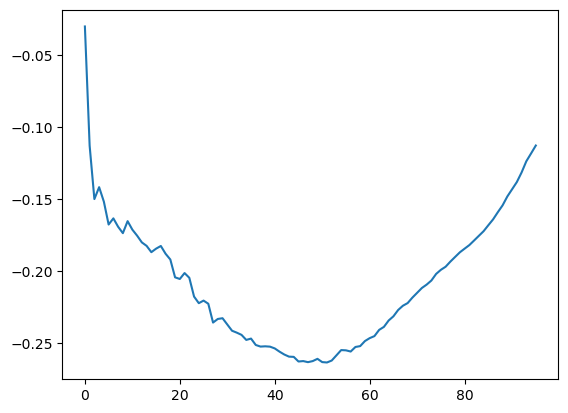

In [6]:
Y_new = Y.flatten()

plt.plot(Y_new[:96])

Also, the input X needs to incorporate the k bins, so each cosmological parameter needs to repeat for numel(k) times.

In [7]:
# Each X needs to corresponsing to numel(k) bins,
# so repeat each X for numel(k) times.
X_new = np.repeat(
    X,
    len(_kf),
    axis=0
)

print("Shape of repeated X:", X_new.shape)

# k bins need to repeat for numel(X) times,
# so each input X could have a vector of k bins.
kf_new = np.concatenate(
    [
        _kf[:, None] for i in range(len(X))
    ],
    axis=0
)

print("Shape of repeated kf:", kf_new.shape)

X = np.concatenate(
    [
        X_new, kf_new
    ],
    axis = 1
)

print("Shape of new X", X.shape)
X[:5] # preview of few lines to make sure

Shape of repeated X: (34560, 5)
Shape of repeated kf: (34560, 1)
Shape of new X (34560, 6)


array([[0.15833333, 0.59166667, 0.14166667, 0.55833333, 0.95833333,
        0.        ],
       [0.15833333, 0.59166667, 0.14166667, 0.55833333, 0.95833333,
        0.19093374],
       [0.15833333, 0.59166667, 0.14166667, 0.55833333, 0.95833333,
        0.25768056],
       [0.15833333, 0.59166667, 0.14166667, 0.55833333, 0.95833333,
        0.28669638],
       [0.15833333, 0.59166667, 0.14166667, 0.55833333, 0.95833333,
        0.30492205]])

In [8]:
Y = Y_new

In [9]:
# train test split
X_test = X[: num_kf * 30]
Y_test = Y[: num_kf * 30]

_X_old = X
_Y_old = Y

X = X[num_kf * 30 : num_kf * 60]
Y = Y[num_kf * 30 : num_kf * 60]

# keep the original train X
X_train = X
Y_train = Y

In [10]:
X.shape, Y.shape

((2880, 6), (2880,))

## Reduce the indexed points

There are too many training points, the computational burden for training a GP becomes very large.

Here to try to resample a subset of the original training set to make the training size smaller.

In [11]:
reduce_size = 200
origin_size = len(X)

ind = np.random.choice(np.arange(origin_size), size=reduce_size, replace=False)

X = X[ind]
Y = Y[ind]

## Build your GP with tensorflow

We want our GP to have Automatic Relevance Determination, which means one lengthscale per feature dimension. This is not implemented in tensorflow probability yet (by the time I wrote the notebook).

The Issue in this thread asked by StarFish team provided a custom ARD kernel (https://github.com/tensorflow/probability/issues/248), which we will be using here.

In [12]:
class InputTransformedKernel(tfk.PositiveSemidefiniteKernel):

  def __init__(self, kernel, transformation, name='InputTransformedKernel'):
    self._kernel = kernel
    self._transformation = transformation
    super(InputTransformedKernel, self).__init__(
        feature_ndims=kernel.feature_ndims,
        dtype=kernel.dtype,
        name=name)

  def apply(self, x1, x2):
    return self._kernel.apply(
        self._transformation(x1),
        self._transformation(x2))

  def matrix(self, x1, x2):
    return self._kernel.matrix(
        self._transformation(x1),
        self._transformation(x2))

  @property
  def batch_shape(self):
    return self._kernel.batch_shape

  def batch_shape_tensor(self):
    return self._kernel.batch_shape_tensor

class InputScaledKernel(InputTransformedKernel):

  def __init__(self, kernel, length_scales):
    super(InputScaledKernel, self).__init__(
        kernel,
        lambda x: x / tf.expand_dims(length_scales,
                                     -(kernel.feature_ndims + 1)))


$$
\begin{align}
f \sim \: & \textsf{GaussianProcess}\left(
    \text{mean_fn}=\mu(x),
    \text{covariance_fn}=k(x, x')\right) \\
y_i \sim \: & \textsf{Normal}\left(
    \text{loc}=f(x_i),
    \text{scale}=\sigma\right), i = 1, \ldots, N
\end{align}
$$

$$
\textsf{lengthscale} \sim \textsf{LogNormal}(\mu, \sigma)\\
\textsf{amplitude} \sim \textsf{LogNormal}(\mu, \sigma)
$$

No need to make a batch of GP this time, but need to make a multiplied kernel,

K <- K(x, x') * K(k, k')

The recommended way to implement active_dim is to use FeatureTransformed.

https://github.com/tensorflow/probability/issues/862

```python
eq_indices = [0, 2, 4]
periodic_indices = [1, 3]
eq_kernel = tfp.math.psd_kernels.FeatureTransformed(
    tfp.math.psd_kernels.ExponentiatedQuadratic(...),
    transformation_fn=lambda x: tf.gather(x, eq_indices, axis=-1))
periodic_kernel = tfp.math.psd_kernels.FeatureTransformed(
    tfp.math.psd_kernels.ExpSinSquared(...),
    transformation_fn=lambda x: tf.gather(x, periodic_indices, axis=-1))

kernel = eq_kernel + periodic_kernel
```

In [13]:
num_examples, num_features = X.shape
num_examples  = Y.shape

X.shape, Y.shape

((200, 6), (200,))

In [14]:
from typing import List

In [15]:
class ActiveDimension(tfk.FeatureTransformed):

    def __init__(
        self,
        kernel,
        active_dim: List,
        validate_args=False,
        parameters=None,
        name='ActiveDim'
) -> None:
        self._transformation_fn = lambda x, feature_ndims, param_expansion_ndims : tf.gather(x, active_dim, axis=-1,)

        super(ActiveDimension, self).__init__(
            kernel=kernel,
            transformation_fn=self._transformation_fn,
            validate_args=validate_args,
            parameters=parameters,
            name=name,
        )

        # Keep the kernel so that we can get the batch shape
        self._kernel = kernel

    @property
    def batch_shape(self):
        return self._kernel.batch_shape

    def batch_shape_tensor(self):
        return self._kernel.batch_shape_tensor


# class ActiveDimension(InputTransformedKernel):

#   def __init__(self, kernel, active_dim: List):
#     super(ActiveDimension, self).__init__(
#         kernel,
#         lambda x: tf.gather(x, active_dim, axis=-1,)
#     )


In [16]:
active_dim_x = [0, 1, 2, 3, 4]
active_dim_k = [5]

def build_gp(
        amplitude, length_scales,    # lengthscales in ARD
        amplitude_k, length_scale_k, # lengthscale not in ARD
        observation_noise_variance
    ):
    """
    Defines the conditional dist. of GP outputs, given kernel parameters.

    Kernel = SE(x, x') SE(k, k')

    """
    # Create the covariance kernel, which will be shared between the prior (which we
    # use for maximum likelihood training) and the posterior (which we use for
    # posterior predictive sampling)
    se_kernel = tfk.ExponentiatedQuadratic(
        amplitude,
    )
    # jibancat: This is our ARD kernel, with 1 lengthscale per feature dim
    ard_kernel = ActiveDimension(
        InputScaledKernel(se_kernel, length_scales = length_scales),
        active_dim=active_dim_x,
    )

    # Create another kernel over k. No need to have ARD in this case.
    se_k_kernel = ActiveDimension(
        tfk.ExponentiatedQuadratic(
        amplitude_k, length_scale_k),
        active_dim=active_dim_k,
    )

    kernel = ard_kernel * se_k_kernel

    # Create the GP prior distribution, which we will use to train the model
    # parameters.
    return tfd.GaussianProcess(
        kernel=kernel,
        index_points=X,
        # jibancat: I comment out the observation noise. But if it's necessary, add it back.
        observation_noise_variance=observation_noise_variance
    )

# jibancat: Build the joint distribution over priors + GP likelihood
gp_joint_model = tfd.JointDistributionNamed({
    # Prior over amplitude. Note that we have a mixture of independent GPs with size of num_outputs
    'amplitude':
        tfd.LogNormal(
            loc=np.float64(0.),
            scale=np.float64(1.),                                # roughly move lengthscale to center around 1
    ),
    # Prior over lengthscales. Note that we have a mixture of independent GPs with size of num_outputs
    # Also, we need another dimension of features.
    # To avoid tensowflow getting confused, we use tfd.Independent to re-interpret the dimension
    # of features as part of the distribution instead of "batch". Now, the batch dimension is num_outputs.
    'length_scales':
        tfd.Independent(
        tfd.LogNormal(
            loc=np.ones([num_features - 1]) * 0.0,
            scale=np.ones([num_features - 1]) * 1.,              # roughly move lengthscale to center around 1
    ), reinterpreted_batch_ndims=1),
    'amplitude_k':
        tfd.LogNormal(
            loc=np.float64(0.),
            scale=np.float64(1.),                                # roughly move lengthscale to center around 1
    ),
    'length_scale_k':
        tfd.LogNormal(
            loc=np.float64(0.),
            scale=np.float64(1.),                                  # roughly move lengthscale to center around 1
    ),
    'observation_noise_variance':
        tfd.LogNormal(
            loc=np.float64(0.),
            scale=np.float64(1.)
    ),
    'observations': build_gp,
})

In [17]:
# jibancat: check again. You should see the batch dimension is the number of k bins, num_outputs.
gp_joint_model.batch_shape

Instructions for updating:
`jitter` is deprecated; please use `marginal_fn` directly.
Instructions for updating:
`always_yield_multivariate_normal` is deprecated. After 2023-02-15, this arg will be ignored, and behavior will be as though `always_yield_multivariate_normal=True`. This means that a`GaussianProcessRegressionModel` evaluated at a single index point will have event shape `[1]`. To reproduce the behavior of `always_yield_multivariate_normal=False` squeeze the rightmost singleton dimension from the output of `mean`, `sample`, etc.


/Users/jibanmac/Documents/conda/tensorflow/lib/python3.9/site-packages/tensorflow_probability/python/distributions/gaussian_process.py:501: FutureWarning: When the `always_yield_multivariate_normal` arg to `GaussianProcess.__init__` is ignored, after 2023-02-15, `get_marginal_distribution` will always return a Normal distribution with vector event shape. This is the current behavior when `always_yield_multivariate_normal=True`. To recover the behavior of `always_yield_multivariate_normal=False` when `index_points` contains a single index point, build a scalar `Normal` distribution as follows: `mvn = get_marginal_distribution(index_points); ``norm = tfd.Normal(mvn.loc[..., 0], scale=mvn.stddev()[..., 0])`. To suppress these warnings, build the `GaussianProcess` with `always_yield_multivariate_normal=True`.
  warnings.warn(


{'observation_noise_variance': TensorShape([]),
 'length_scales': TensorShape([]),
 'length_scale_k': TensorShape([]),
 'amplitude_k': TensorShape([]),
 'amplitude': TensorShape([]),
 'observations': TensorShape([])}

In [18]:
x = gp_joint_model.sample()
lp = gp_joint_model.log_prob(x)

print("sampled {}".format(x))
print("log_prob of sample: {}".format(lp))

sampled {'observation_noise_variance': <tf.Tensor: shape=(), dtype=float64, numpy=1.575967901810652>, 'length_scales': <tf.Tensor: shape=(5,), dtype=float64, numpy=array([ 1.64018813,  1.67613163, 10.92600228, 16.31144722,  1.10539728])>, 'length_scale_k': <tf.Tensor: shape=(), dtype=float64, numpy=0.733582160559495>, 'amplitude_k': <tf.Tensor: shape=(), dtype=float64, numpy=2.907813060073946>, 'amplitude': <tf.Tensor: shape=(), dtype=float64, numpy=2.678944347772971>, 'observations': <tf.Tensor: shape=(200,), dtype=float64, numpy=
array([ -5.78634338,   0.82507337,   3.26898731,  -0.4762091 ,
        -6.65888909,   2.38712815,  -0.29251958,   5.71405376,
        -2.79323748,  -1.27973523,  -6.00640026,  -7.86592525,
        -2.62493878,  -4.6210722 ,   1.31896845,   4.21121456,
        -3.22637569,   1.88218058,  -4.35910057,  -0.30177507,
         1.77504656,  -8.86753367,  -3.49268504,   2.14130575,
         2.96178063,  -0.10404502,   2.65085788,   4.63463587,
        -6.28663447, 

In [19]:
# Create the trainable model parameters, which we'll subsequently optimize.
# Note that we constrain them to be strictly positive.

constrain_positive = tfb.Shift(np.finfo(np.float64).tiny)(tfb.Exp())

amplitude_var = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='amplitude',
    dtype=np.float64)

length_scale_var = tfp.util.TransformedVariable(
    initial_value=np.ones([num_features - 1]) * 1.0,
    bijector=constrain_positive,
    name='length_scale',
    dtype=np.float64)


amplitude_var_k = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='amplitude_k',
    dtype=np.float64)

length_scale_var_k = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='length_scale_k',
    dtype=np.float64)


observation_noise_variance_var = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='observation_noise_variance_var',
    dtype=np.float64)

trainable_variables = [v.trainable_variables[0] for v in 
                       [
                        amplitude_var,
                        length_scale_var,
                        amplitude_var_k,
                        length_scale_var_k,
                       observation_noise_variance_var
                    ]]

In [20]:
def target_log_prob(
        amplitude, length_scale,    # lengthscales in ARD
        amplitude_k, length_scale_k, # lengthscale not in ARD
        observation_noise_variance,
):
  return gp_joint_model.log_prob({
      'amplitude': amplitude,
      'length_scales': length_scale,
      'amplitude_k' : amplitude_k,
      'length_scale_k' : length_scale_k,
      'observation_noise_variance': observation_noise_variance,
      'observations': Y
  })

In [21]:
# Now we optimize the model parameters.
num_iters = 3000                                    # jibancat: these two numbers need to tune
optimizer = tf.optimizers.Adam(learning_rate=5e-2)  # jibancat: these two numbers need to tune

# Use `tf.function` to trace the loss for more efficient evaluation.
@tf.function(autograph=False, jit_compile=False)
def train_model():
  with tf.GradientTape() as tape:
    loss = -target_log_prob(amplitude_var, length_scale_var,
                            amplitude_var_k, length_scale_var_k,
                            observation_noise_variance_var
                            )

  grads = tape.gradient(loss, trainable_variables)
  optimizer.apply_gradients(zip(grads, trainable_variables))
  return loss

# Store the likelihood values during training, so we can plot the progress
lls_ = np.zeros(num_iters, np.float64)
for i in range(num_iters):
  loss = train_model()
  lls_[i] = loss

print('Trained parameters:')
print('amplitude: {}'.format(amplitude_var._value().numpy()))
print('length_scale: {}'.format(length_scale_var._value().numpy()))
print('amplitude_k: {}'.format(amplitude_var_k._value().numpy()))
print('length_scale_l: {}'.format(length_scale_var_k._value().numpy()))
print('observation_noise_variance: {}'.format(observation_noise_variance_var._value().numpy()))

2022-12-28 17:03:47.096058: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Trained parameters:
amplitude: 0.5470584366849193
length_scale: [ 0.980635    3.6617129   2.37372076  2.61957094 10.39150106]
amplitude_k: 0.547058436688005
length_scale_l: 0.24414171070973248
observation_noise_variance: 6.560527439038165e-06


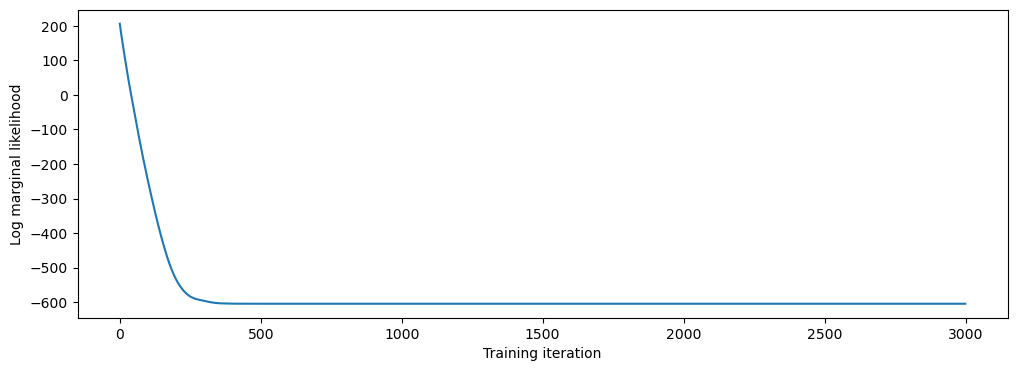

In [22]:
# Plot the loss evolution
plt.figure(figsize=(12, 4))
plt.plot(lls_ )
plt.xlabel("Training iteration")
plt.ylabel("Log marginal likelihood")
plt.show()

## Sample from conditional GP

In [23]:
# Having trained the model, we'd like to sample from the posterior conditioned
# on observations. We'd like the samples to be at points other than the training
# inputs.

# jibancat: Cosmological parameters in this case is in dim of 
# (n_examples, 5 features)

# Test input cosmologies
predictive_index_points_ = X_test

optimized_se_kernel = tfk.ExponentiatedQuadratic(
    amplitude_var,
)
# jibancat: This is our ARD kernel, with 1 lengthscale per feature dim
optimized_ard_kernel = ActiveDimension(
    InputScaledKernel(optimized_se_kernel, length_scales = length_scale_var),
    active_dim=active_dim_x,
)
# Create another kernel over k. No need to have ARD in this case.
optimized_se_k_kernel = ActiveDimension(
    tfk.ExponentiatedQuadratic(
    amplitude_var_k, length_scale_var_k),
    active_dim=active_dim_k,
)
optimized_kernel = optimized_ard_kernel * optimized_se_k_kernel

# Create the GP prior distribution, which we will use to train the model
# parameters.
gprm = tfd.GaussianProcessRegressionModel(
    kernel=optimized_kernel,
    index_points=predictive_index_points_,
    observation_index_points=X,
    observations=Y,
    observation_noise_variance=observation_noise_variance_var,
    predictive_noise_variance=0.)


# Create op to draw  50 independent samples, each of which is a *joint* draw
# from the posterior at the predictive_index_points_. Since we have 200 input
# locations as defined above, this posterior distribution over corresponding
# function values is a 200-dimensional multivariate Gaussian distribution!
num_samples = 50
samples = gprm.sample(num_samples)

Instructions for updating:
`always_yield_multivariate_normal` is deprecated. After 2023-02-15, this arg will be ignored, and behavior will be as though `always_yield_multivariate_normal=True`. This means that a`GaussianProcessRegressionModel` evaluated at a single index point will have event shape `[1]`. To reproduce the behavior of `always_yield_multivariate_normal=False` squeeze the rightmost singleton dimension from the output of `mean`, `sample`, etc.


In [24]:
# reshape the samples to be (num samples, num examples, num k bins)
numpy_samples = samples.numpy()
numpy_samples = numpy_samples.reshape(num_samples, int(numpy_samples.shape[1] // num_kf), num_kf )

y_test = Y_test.reshape(Y_test.shape[0] // num_kf, num_kf).T

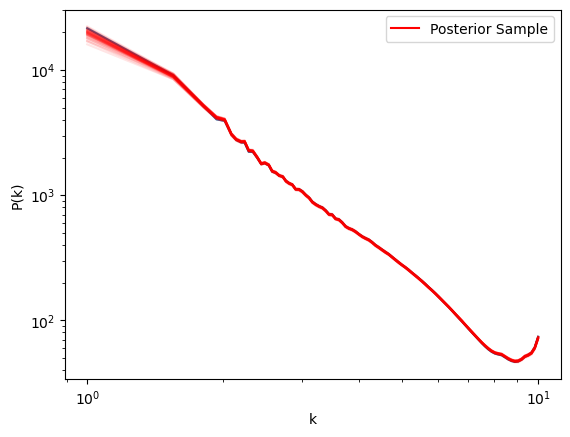

In [25]:
# plot the Pk comparison: GP predictions versus true Pk
test_i = 20

plt.loglog(10**_kf, 10**(y_test[:, test_i] + Y_mean))

for i in range(num_samples):
    plt.loglog(10**_kf, 10**(numpy_samples[i, test_i, :] + Y_mean),
        c='r', alpha=.1,
        label='Posterior Sample' if i == 0 else None
    )


leg = plt.legend(loc='upper right')
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.xlabel(r"k")
plt.ylabel("P(k)")
plt.show()

(1.1, 0.9)

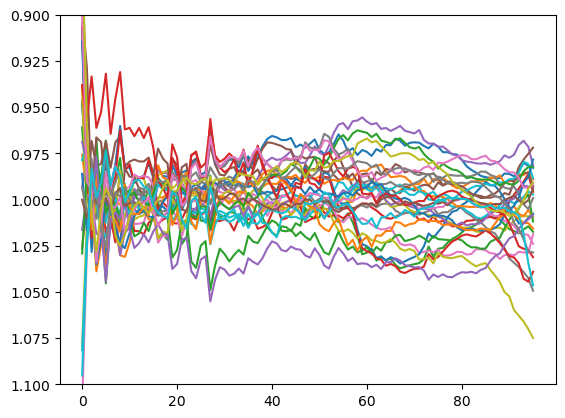

In [26]:
pred_exact = 10**(numpy_samples.mean(axis=0).T + Y_mean[:, None]) / 10**(
    y_test + Y_mean[:, None]
)
plt.plot(pred_exact)

plt.ylim(1.10, 0.9)

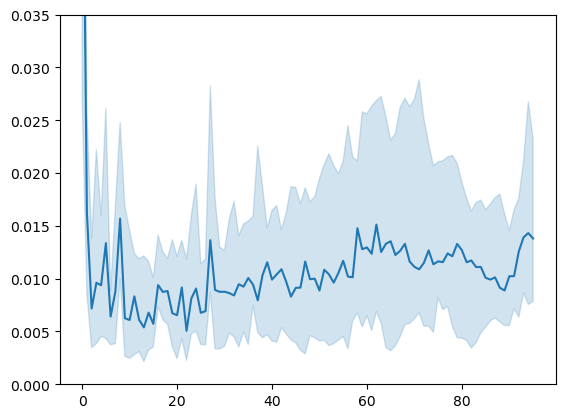

In [27]:
lower_error, median_error, upper_error = np.quantile(np.abs(pred_exact - 1), [0.25, 0.5, 0.75], axis=1)

plt.plot(median_error)
plt.fill_between(
    np.arange(pred_exact.shape[0]),
    y1=lower_error,
    y2=upper_error,
    color="C0",
    alpha=0.2
)

plt.ylim(0, 0.035)

# jibancat save the variable for later use
_pred_exact_map = pred_exact

In [28]:
# sample from training points
gprm_train = tfd.GaussianProcessRegressionModel(
    kernel=optimized_kernel,
    index_points=X_train,
    observation_index_points=X,
    observations=Y,
    observation_noise_variance=observation_noise_variance_var,
    predictive_noise_variance=0.)

# Create op to draw  50 independent samples, each of which is a *joint* draw
# from the posterior at the predictive_index_points_. Since we have 200 input
# locations as defined above, this posterior distribution over corresponding
# function values is a 200-dimensional multivariate Gaussian distribution!
num_samples = 50
samples_train = gprm_train.sample(num_samples)

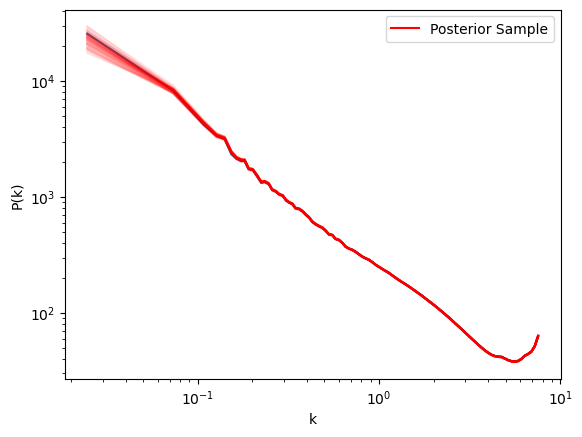

In [29]:
# plot the Pk comparison: GP predictions versus true Pk
train_i = 0

numpy_samples_train = samples_train.numpy()
numpy_samples_train = numpy_samples_train.reshape(num_samples, int(numpy_samples_train.shape[1] // num_kf), num_kf )

y_train = Y_train.reshape(Y_train.shape[0] // num_kf, num_kf).T

plt.loglog(10**kf, 10**(y_train[:, train_i] + Y_mean))

for i in range(num_samples):
    plt.loglog(10**kf, 10**(numpy_samples_train[i, train_i, :] + Y_mean),
        c='r', alpha=.1,
        label='Posterior Sample' if i == 0 else None
    )

leg = plt.legend(loc='upper right')
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.xlabel(r"k")
plt.ylabel("P(k)")
plt.show()

(0.9, 1.1)

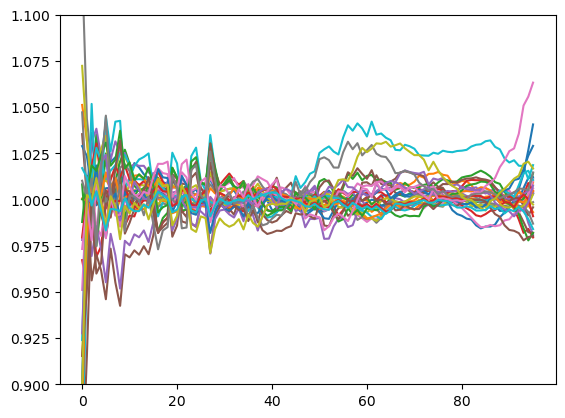

In [30]:
pred_exact_train = 10**(numpy_samples_train.mean(axis=0).T + Y_mean[:, None]) / 10**(
    y_train + Y_mean[:, None]
)
plt.plot(pred_exact_train)

plt.ylim(0.9, 1.1)

(0.0, 0.035)

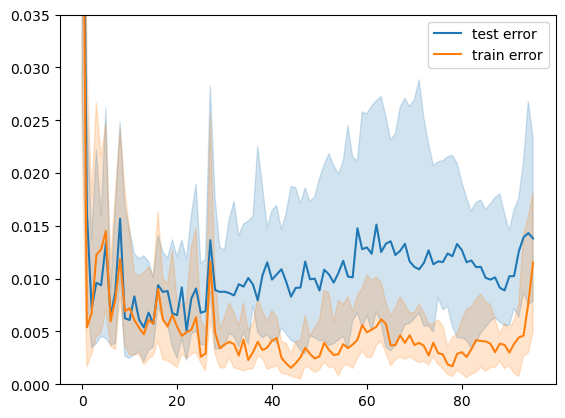

In [31]:
lower_error_train, median_error_train, upper_error_train = np.quantile(np.abs(pred_exact_train - 1), [0.25, 0.5, 0.75], axis=1)

plt.plot(median_error, label="test error")
plt.fill_between(
    np.arange(pred_exact.shape[0]),
    y1=lower_error,
    y2=upper_error,
    color="C0",
    alpha=0.2
)

plt.plot(median_error_train, color="C1", label="train error")
plt.fill_between(
    np.arange(pred_exact.shape[0]),
    y1=lower_error_train,
    y2=upper_error_train,
    color="C1",
    alpha=0.2
)

plt.legend()

plt.ylim(0, 0.035)

## Marginalizing hyperparameters with HMC

Instead of optimizing the hyperparameters, let's try integrating them out with Hamiltonian Monte Carlo. We'll first define and run a sampler to approximately draw from the posterior distribution over kernel hyperparameters, given the observations.

The example here is not so different from tensorflow's example, except we have additional num_outputs and num_features dimensions.

In [39]:
num_results = 100
num_burnin_steps = 50

sampler = tfp.mcmc.TransformedTransitionKernel(
    tfp.mcmc.NoUTurnSampler(
        target_log_prob_fn=target_log_prob,
        step_size=tf.cast(0.1, tf.float64)),
    bijector=[constrain_positive, constrain_positive, constrain_positive,
        constrain_positive, constrain_positive
        ]    
    )

adaptive_sampler = tfp.mcmc.DualAveragingStepSizeAdaptation(
    inner_kernel=sampler,
    num_adaptation_steps=int(0.8 * num_burnin_steps),
    target_accept_prob=tf.cast(0.75, tf.float64))

# jibancat: initial values start with MAP estimation to save burning time
initial_state = [
    amplitude_var,
    length_scale_var,
    amplitude_var_k,
    length_scale_var_k,
    observation_noise_variance_var
]

In [40]:
# Speed up sampling by tracing with `tf.function`.
@tf.function(autograph=False, jit_compile=False)
def do_sampling():
  return tfp.mcmc.sample_chain(
      kernel=adaptive_sampler,
      current_state=initial_state,
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      trace_fn=lambda current_state, kernel_results: kernel_results)

t0 = time.time()
samples, kernel_results = do_sampling()
t1 = time.time()
print("Inference ran in {:.2f}s.".format(t1-t0))

Inference ran in 15.88s.


Check the trace of the MCMC chains

In [41]:
(amplitude_samples,
 length_scale_samples,
 amplitude_k_samples,
 length_scale_k_samples,
 observation_noise_variance_samples) = samples

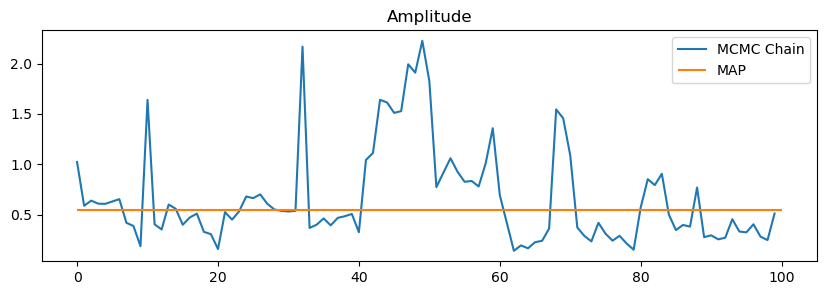

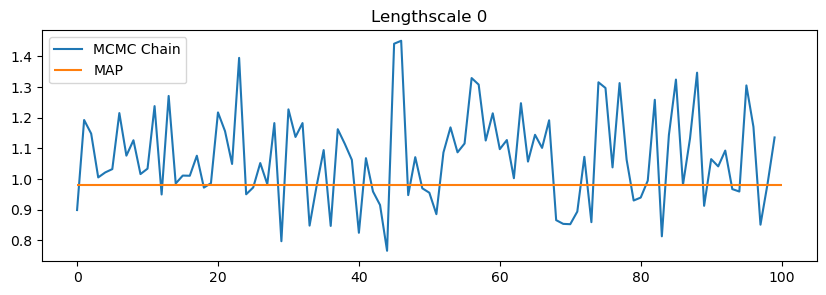

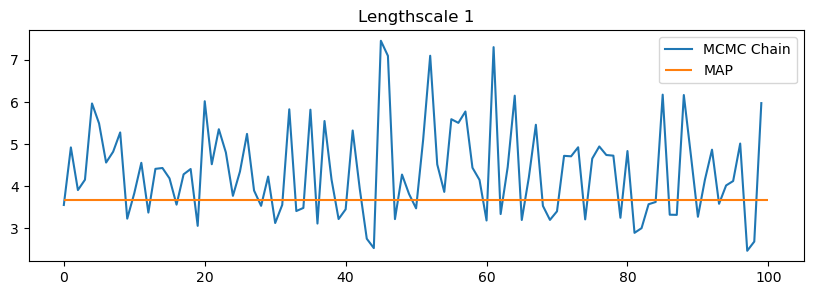

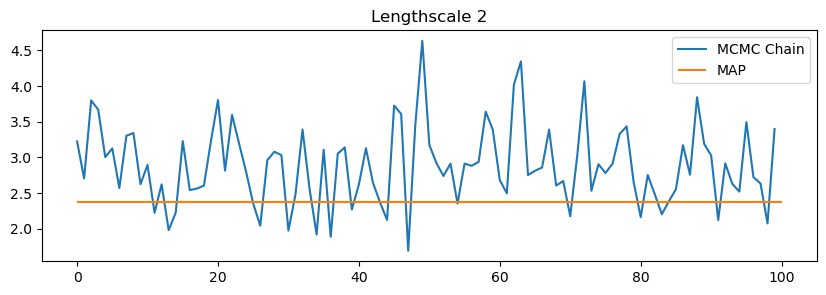

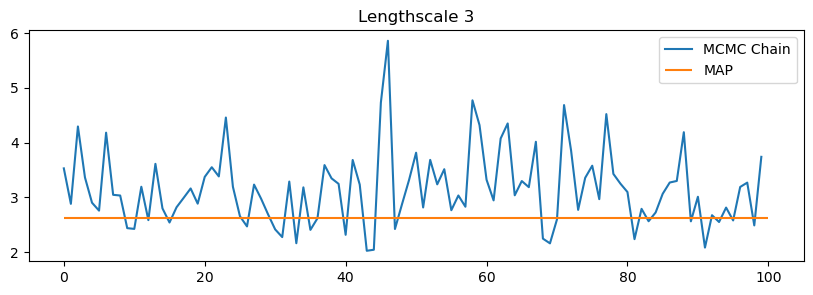

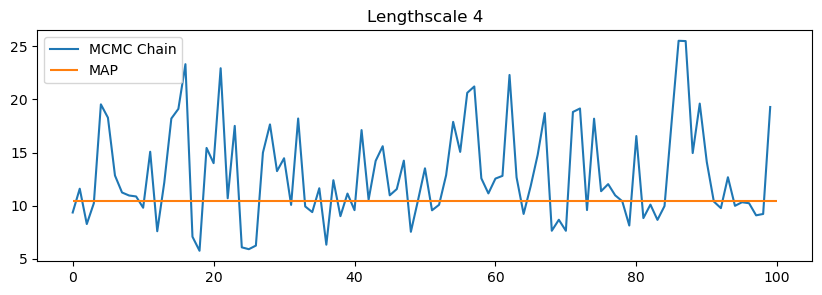

In [42]:
# check some of the chains

plt.figure(figsize=[10, 3])
plt.title("Amplitude")
plt.plot(amplitude_samples, label="MCMC Chain")
plt.hlines(amplitude_var.numpy(), 0, num_results, colors="C1", label="MAP")
plt.legend()
plt.show()

for i in range(num_features - 1):
    plt.figure(figsize=[10, 3])
    plt.title("Lengthscale {}".format(i))
    plt.plot(length_scale_samples[:, i], label="MCMC Chain")
    plt.hlines(length_scale_var.numpy()[i], 0, num_results, colors="C1", label="MAP")
    plt.legend()
    plt.show()

Text(0, 0.5, 'Amplitude k')

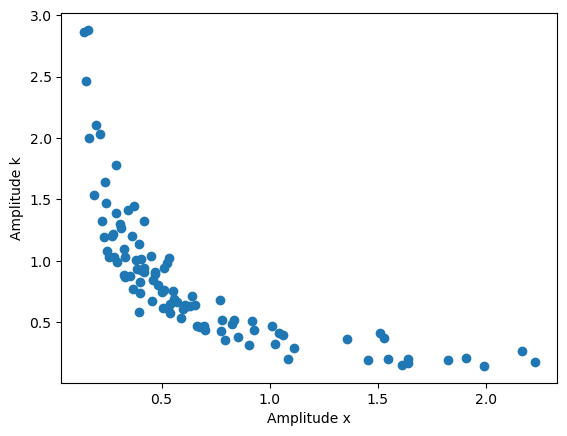

In [43]:
plt.scatter(amplitude_samples, amplitude_k_samples)

plt.xlabel("Amplitude x")
plt.ylabel("Amplitude k")

Text(0, 0.5, 'Lengthscale k')

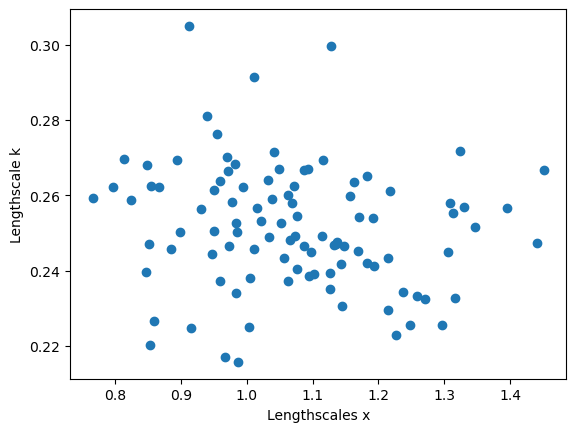

In [44]:
plt.scatter(length_scale_samples[:, 0], length_scale_k_samples)

plt.xlabel("Lengthscales x")
plt.ylabel("Lengthscale k")

Sample from the MCMC results using a batch of GPs

In [57]:
# The sampled hyperparams have a leading batch dimension, `[num_results, ...]`,
# so they construct a *batch* of kernels.

# jibancat: Cosmological parameters in this case is in dim of 
# (n_examples, 5 features)

# Test input cosmologies
totla_test_i = 30
x_test = X_test[:num_kf * totla_test_i]
y_test = Y_test[:num_kf * totla_test_i]

predictive_index_points_ = x_test

batch_of_posterior_se_kernel = tfk.ExponentiatedQuadratic(
    amplitude_samples,
)
# jibancat: This is our ARD kernel, with 1 lengthscale per feature dim
batch_of_posterior_ard_kernel = ActiveDimension(
    InputScaledKernel(
        batch_of_posterior_se_kernel, length_scales = length_scale_samples),
    active_dim=active_dim_x,
)
# Create another kernel over k. No need to have ARD in this case.
batch_of_posterior_se_k_kernel = ActiveDimension(
    tfk.ExponentiatedQuadratic(
    amplitude_k_samples, length_scale_k_samples),
    active_dim=active_dim_k,
)
batch_of_posterior_kernel = batch_of_posterior_ard_kernel * batch_of_posterior_se_k_kernel

# The batch of kernels creates a batch of GP predictive models, one for each
# posterior sample.
batch_gprm = tfd.GaussianProcessRegressionModel(
    kernel=batch_of_posterior_kernel,
    index_points=predictive_index_points_,
    observation_index_points=X,
    observations=Y,
    observation_noise_variance=observation_noise_variance_samples,
    predictive_noise_variance=0.)


# To construct the marginal predictive distribution, we average with uniform
# weight over the posterior samples.
predictive_gprm = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(
        logits=tf.zeros([num_results])
    ),
    components_distribution=batch_gprm,
)

Peak memory ~120 GB. Likely not runable on a normal laptop.

In [58]:
num_samples = 50
samples = predictive_gprm.sample(num_samples)

In [59]:
# reshape the samples to be (num samples, num examples, num k bins)
numpy_samples = samples.numpy()
numpy_samples = numpy_samples.reshape(num_samples, int(numpy_samples.shape[1] // num_kf), num_kf )

_y_test = y_test.reshape(y_test.shape[0] // num_kf, num_kf).T
_y_test.shape

(96, 30)

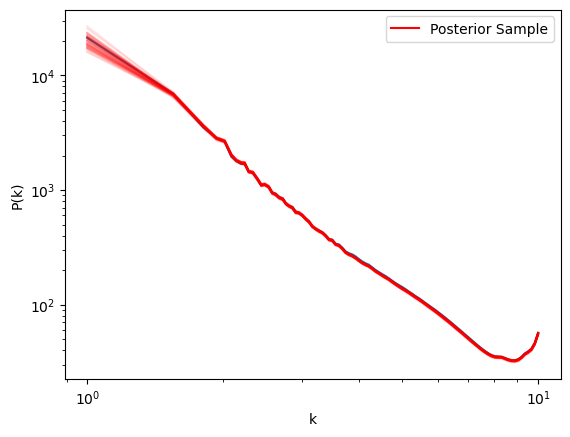

In [60]:
# plot the Pk comparison: GP predictions versus true Pk
test_i = 0

plt.loglog(10**_kf, 10**(_y_test[:, test_i] + Y_mean))

for i in range(num_samples):
    plt.loglog(10**_kf, 10**(numpy_samples[i, test_i, :] + Y_mean),
        c='r', alpha=.1,
        label='Posterior Sample' if i == 0 else None
    )


leg = plt.legend(loc='upper right')
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.xlabel(r"k")
plt.ylabel("P(k)")
plt.show()

(1.1, 0.9)

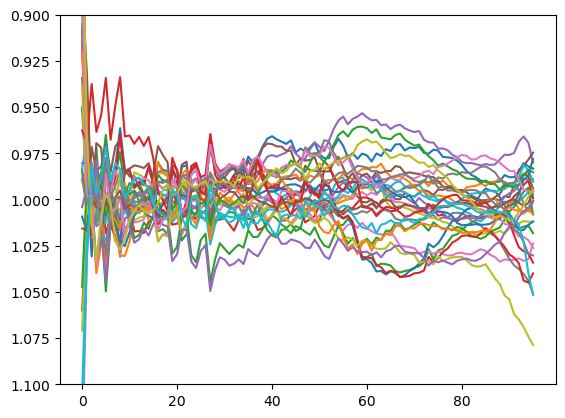

In [61]:
pred_exact = 10**(numpy_samples.mean(axis=0).T + Y_mean[:, None]) / 10**(
    _y_test + Y_mean[:, None]
)
plt.plot(pred_exact)

plt.ylim(1.10, 0.9)

(0.0, 0.035)

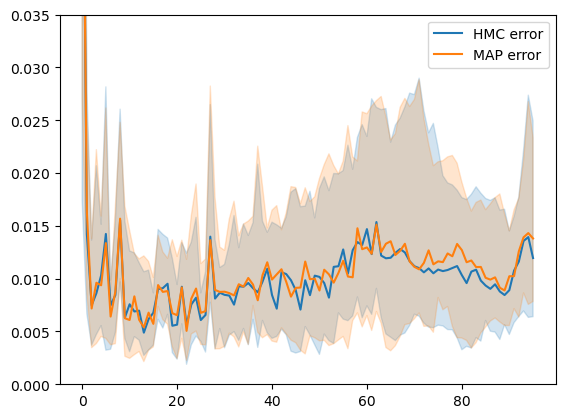

In [62]:
lower_error, median_error, upper_error = np.quantile(np.abs(pred_exact - 1), [0.25, 0.5, 0.75], axis=1)

plt.plot(median_error, label="HMC error")
plt.fill_between(
    np.arange(pred_exact.shape[0]),
    y1=lower_error,
    y2=upper_error,
    color="C0",
    alpha=0.2
)

# MAP estimate error
lower_error_map, median_error_map, upper_error_map = np.quantile(np.abs(_pred_exact_map - 1), [0.25, 0.5, 0.75], axis=1)

plt.plot(median_error_map, label="MAP error")
plt.fill_between(
    np.arange(pred_exact.shape[0]),
    y1=lower_error_map,
    y2=upper_error_map,
    color="C1",
    alpha=0.2
)

plt.legend()

plt.ylim(0, 0.035)

Not a big difference.

In [63]:
import h5py

with h5py.File("../data/360_res128box256_9_res512box256_z0/hmc_samples_lf_30_K(k).hdf5", "w") as f:
    f.create_dataset("length_scale_samples", data=length_scale_samples.numpy())
    f.create_dataset("amplitude_samples", data=amplitude_samples.numpy())
    f.create_dataset("length_scale_k_samples", data=length_scale_k_samples.numpy())
    f.create_dataset("amplitude_k_samples", data=amplitude_k_samples.numpy())    
    f.create_dataset("predictive_samples", data=samples.numpy())